# Using machine learning XGboost classifier to look for different pattern between Ketamin and Midazolam groups

In [121]:
# import relevant packages
import glob
import numpy as np
import scipy
import nilearn
import nilearn.plotting
import nilearn.input_data
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

## No apperant contribution to before/after treatment in general. 
- Lets look at group differences in ROIs $\rightarrow$
    * vmPFC
    * Hippocampus
    
- We compare pattern of ROI activation in the trauma > relax contrast on the 2nd day

In [122]:
# compare between groups
import pandas as pd
medication_cond = pd.read_csv('kpe_sub_condition.csv')


ketamine_list = list(medication_cond['scr_id'][medication_cond['med_cond']==1])
ket_list = []
for subject in ketamine_list:
    
    sub = subject.split('KPE')[1]
    ket_list.append(sub)


midazolam_list = list(medication_cond['scr_id'][medication_cond['med_cond']==0])
mid_list = []
for subject in midazolam_list:
    
    sub = subject.split('KPE')[1]
    mid_list.append(sub)
#mid_list.remove('1480')

In [123]:
print(ket_list)
print(mid_list)

['008', '1223', '1293', '1307', '1315', '1322', '1339', '1343', '1387', '1419', '1464', '1499', '1573']
['1253', '1263', '1351', '1356', '1364', '1369', '1390', '1403', '1468', '1480', '1561', '1578']


In [124]:
mid_list
## only for 3rd session
ket_list.remove('1315')

In [234]:
# remove subjects in session 3
mid_list.remove('1253')
mid_list.remove('1468')
mid_list.remove('1480')

In [125]:
# only in 2nd session
mid_list.remove('1578')
# only for 3rd session
#mid_list.remove('1253')
#mid_list.remove('1480')

In [126]:
ses = '2'
ket_func = ['/gpfs/gibbs/pi/levy_ifat/Or/kpe/results/ScriptPart_ses%s_Nosmooth/modelfit/_subject_id_%s/modelestimate/results/cope7.nii.gz'% (ses,sub) for sub in ket_list]
mid_func = ['/gpfs/gibbs/pi/levy_ifat/Or/kpe/results/ScriptPart_ses%s_Nosmooth/modelfit/_subject_id_%s/modelestimate/results/cope7.nii.gz'% (ses,sub) for sub in mid_list]

In [237]:
# set n folds
# In session 3 there are many NAs from Midazolam. So we set different fold than LOO (per group)
n_folds= 7 #for 3rd session

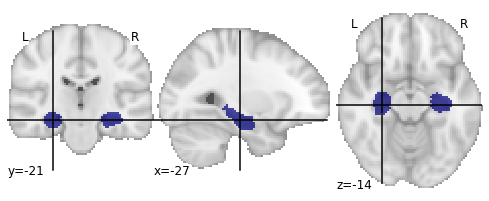

In [127]:
mask_file = '/gpfs/gibbs/pi/levy_ifat/Or/ROI/hippocampus_association-test_z_FDR_0.01.nii.gz'
mask_file = nilearn.image.math_img("a>=13", a=mask_file)
%matplotlib inline
nilearn.plotting.plot_roi(mask_file)#, display_mode='x', cut_coords=[-26], annotate=False)
masker = nilearn.input_data.NiftiMasker(mask_img=mask_file, 
                               sessions=None, smoothing_fwhm=2,
                                        standardize=False, 
                                        detrend=False, verbose=5)

In [128]:
ketamine = []
for func in ket_func:
    print(f'Running {func}')
    beta = masker.fit_transform(func)
    ketamine.append(beta)

midazolam = []
for func in mid_func:
    print(f'Running {func}')
    beta = masker.fit_transform(func)
    midazolam.append(beta)

ketArr = np.array(ketamine)
ketArr_reshape= np.array(ketArr).reshape(ketArr.shape[0], ketArr.shape[2])
ketArr_reshape.shape


midArr = np.array(midazolam)
midArr_reshape= np.array(midArr).reshape(midArr.shape[0], midArr.shape[2])
midArr_reshape.shape


## Create condition labels (1 = plus, 0 = minus)
label1 = [1] * ketArr.shape[0]
label2 = [0] * midArr.shape[0]
condition_label = np.concatenate([label1, label2])
condition_label

X = np.concatenate([ketArr, midArr])
X = X.reshape(X.shape[0], midArr_reshape.shape[1])
X.shape

Running /gpfs/gibbs/pi/levy_ifat/Or/kpe/results/ScriptPart_ses2_Nosmooth/modelfit/_subject_id_008/modelestimate/results/cope7.nii.gz
[NiftiMasker.fit] Loading data from None
[NiftiMasker.fit] Resampling mask
[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(97, 115, 97, 1),
affine=array([[   2. ,    0. ,    0. ,  -96.5],
       [   0. ,    2. ,    0. , -132.5],
       [   0. ,    0. ,    2. ,  -78.5],
       [   0. ,    0. ,    0. ,  
[NiftiMasker.transform_single_imgs] Resampling images
[NiftiMasker.transform_single_imgs] Smoothing images
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals
Running /gpfs/gibbs/pi/levy_ifat/Or/kpe/results/ScriptPart_ses2_Nosmooth/modelfit/_subject_id_1223/modelestimate/results/cope7.nii.gz
[NiftiMasker.fit] Loading data from None
[NiftiMasker.fit] Resampling mask
[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(97, 115, 97, 1),
affin

[NiftiMasker.transform_single_imgs] Cleaning extracted signals
Running /gpfs/gibbs/pi/levy_ifat/Or/kpe/results/ScriptPart_ses2_Nosmooth/modelfit/_subject_id_1253/modelestimate/results/cope7.nii.gz
[NiftiMasker.fit] Loading data from None
[NiftiMasker.fit] Resampling mask
[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(97, 115, 97, 1),
affine=array([[   2. ,    0. ,    0. ,  -96.5],
       [   0. ,    2. ,    0. , -132.5],
       [   0. ,    0. ,    2. ,  -78.5],
       [   0. ,    0. ,    0. ,  
[NiftiMasker.transform_single_imgs] Resampling images
[NiftiMasker.transform_single_imgs] Smoothing images
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals
Running /gpfs/gibbs/pi/levy_ifat/Or/kpe/results/ScriptPart_ses2_Nosmooth/modelfit/_subject_id_1263/modelestimate/results/cope7.nii.gz
[NiftiMasker.fit] Loading data from None
[NiftiMasker.fit] Resampling mask
[NiftiMasker.transform_single_im

(23, 1265)

In [212]:
n_folds

11

In [213]:
#from sklearn.model_selection import StratifiedKFold
from sklearn.svm import LinearSVC

from sklearn import svm
model = XGBClassifier(n_jobs=7)

## Here we use stratified K-fold with shuffling to generate different shuffling of leave one subject out
cv = StratifiedKFold(n_splits=11, shuffle=True) # running for each subject


In [216]:
scores = cross_val_score(model,
                            X,
                            y=condition_label,
                            cv=cv,
                            groups=condition_label,
                            scoring= "roc_auc",
                            n_jobs=5, # set number of CPUs
                            #verbose = 5 # set some details of the activity 
                            )

In [217]:
scores

array([1., 1., 1., 0., 0., 0., 1., 0., 0., 1., 1.])

## Use shuffle split to randomize and run the XGboost N times
- This will create a distribution of estimation level 
- We can then better estimate how really its more accurate than chance


In [190]:
n_iter = 100
rand_score = []
for i in range(n_iter):
    print(f' Running {i+1} iteration')
    mean_scores = []
    scores = cross_val_score(model,
                            X,
                            y=condition_label,
                            cv=cv,
                            groups=condition_label,
                            scoring= "roc_auc",#"f1",#"accuracy",
                            n_jobs=5, # set number of CPUs
                            #verbose = 5 # set some details of the activity 
                            )
    mean_scores.append(scores.mean())
    rand_score.append(mean_scores)

 Running 1 iteration
 Running 2 iteration
 Running 3 iteration
 Running 4 iteration
 Running 5 iteration
 Running 6 iteration
 Running 7 iteration
 Running 8 iteration
 Running 9 iteration
 Running 10 iteration
 Running 11 iteration
 Running 12 iteration
 Running 13 iteration
 Running 14 iteration
 Running 15 iteration
 Running 16 iteration
 Running 17 iteration
 Running 18 iteration
 Running 19 iteration
 Running 20 iteration
 Running 21 iteration
 Running 22 iteration
 Running 23 iteration
 Running 24 iteration
 Running 25 iteration
 Running 26 iteration
 Running 27 iteration
 Running 28 iteration
 Running 29 iteration
 Running 30 iteration
 Running 31 iteration
 Running 32 iteration
 Running 33 iteration
 Running 34 iteration
 Running 35 iteration
 Running 36 iteration
 Running 37 iteration
 Running 38 iteration
 Running 39 iteration
 Running 40 iteration
 Running 41 iteration
 Running 42 iteration
 Running 43 iteration
 Running 44 iteration
 Running 45 iteration
 Running 46 iterati

### Plotting area under ROC curve ditribution and printing average and standard deviation of the distribution

Area under curve: 0.87 (+/- 0.18)
95% CI is [0.70340909 1.        ]


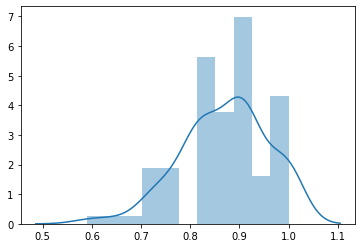

In [191]:
rand_score = np.array(rand_score)
print("Area under curve: %0.2f (+/- %0.2f)" % (np.mean(rand_score), np.std(rand_score) * 2))
print(f'95% CI is {np.quantile(rand_score, [0.025, 0.975])}')
sns.distplot(rand_score)

In [169]:
## use sklearn permutation test
from sklearn.model_selection import permutation_test_score
score, permutation_scores, pvalue = permutation_test_score(
    model, X, condition_label, scoring="roc_auc", cv=cv, n_permutations=50, n_jobs=10, 
    verbose=5, random_state=121)
#roc_auc
print("Classification score %s (pvalue : %s)" % (score, pvalue))

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  42 out of  50 | elapsed:   41.5s remaining:    7.9s


Classification score 0.8181818181818182 (pvalue : 0.1568627450980392)


[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:   44.8s finished


## Now we do similar thing but with vmPFC 
As it might be involved in regular (no reconsolidated) extinction learning

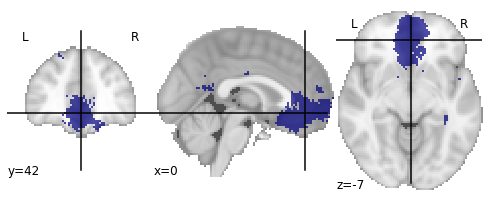

In [210]:
mask_file = '/gpfs/gibbs/pi/levy_ifat/Or/ROI/vmpfc_association-test_z_FDR_0.01.nii.gz'
mask_file = nilearn.image.math_img("a>=2", a=mask_file)
%matplotlib inline
nilearn.plotting.plot_roi(mask_file)
masker = nilearn.input_data.NiftiMasker(mask_img=mask_file, 
                               smoothing_fwhm=1, standardize=True, 
                                        detrend=False, verbose=5)

In [211]:
ketamine = []
for func in ket_func:
    print(f'Running {func}')
    beta = masker.fit_transform(func)
    ketamine.append(beta)

midazolam = []
for func in mid_func:
    print(f'Running {func}')
    beta = masker.fit_transform(func)
    midazolam.append(beta)

ketArr = np.array(ketamine)
ketArr_reshape= np.array(ketArr).reshape(ketArr.shape[0], ketArr.shape[2])
ketArr_reshape.shape


midArr = np.array(midazolam)
midArr_reshape= np.array(midArr).reshape(midArr.shape[0], midArr.shape[2])
midArr_reshape.shape


## Create condition labels (1 = plus, 0 = minus)
label1 = [1] * ketArr.shape[0]
label2 = [0] * midArr.shape[0]
condition_label = np.concatenate([label1, label2])
condition_label

X = np.concatenate([ketArr, midArr])
X = X.reshape(X.shape[0], midArr_reshape.shape[1])
X.shape

Running /gpfs/gibbs/pi/levy_ifat/Or/kpe/results/ScriptPart_ses2_Nosmooth/modelfit/_subject_id_008/modelestimate/results/cope7.nii.gz
[NiftiMasker.fit] Loading data from None
[NiftiMasker.fit] Resampling mask
[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(97, 115, 97, 1),
affine=array([[   2. ,    0. ,    0. ,  -96.5],
       [   0. ,    2. ,    0. , -132.5],
       [   0. ,    0. ,    2. ,  -78.5],
       [   0. ,    0. ,    0. ,  
[NiftiMasker.transform_single_imgs] Resampling images
[NiftiMasker.transform_single_imgs] Smoothing images
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals
Running /gpfs/gibbs/pi/levy_ifat/Or/kpe/results/ScriptPart_ses2_Nosmooth/modelfit/_subject_id_1223/modelestimate/results/cope7.nii.gz
[NiftiMasker.fit] Loading data from None
[NiftiMasker.fit] Resampling mask
[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(97, 115, 97, 1),
affin

/gpfs/ysm/project/levy_ifat/oad4/conda_envs/py37_dev/lib/python3.7/site-packages/nilearn/signal.py:51: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Standardization of 3D signal has been requested but '


[NiftiMasker.transform_single_imgs] Smoothing images
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals
Running /gpfs/gibbs/pi/levy_ifat/Or/kpe/results/ScriptPart_ses2_Nosmooth/modelfit/_subject_id_1293/modelestimate/results/cope7.nii.gz
[NiftiMasker.fit] Loading data from None
[NiftiMasker.fit] Resampling mask
[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(97, 115, 97, 1),
affine=array([[   2. ,    0. ,    0. ,  -96.5],
       [   0. ,    2. ,    0. , -132.5],
       [   0. ,    0. ,    2. ,  -78.5],
       [   0. ,    0. ,    0. ,  
[NiftiMasker.transform_single_imgs] Resampling images


/gpfs/ysm/project/levy_ifat/oad4/conda_envs/py37_dev/lib/python3.7/site-packages/nilearn/signal.py:51: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Standardization of 3D signal has been requested but '


[NiftiMasker.transform_single_imgs] Smoothing images
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals
Running /gpfs/gibbs/pi/levy_ifat/Or/kpe/results/ScriptPart_ses2_Nosmooth/modelfit/_subject_id_1307/modelestimate/results/cope7.nii.gz
[NiftiMasker.fit] Loading data from None
[NiftiMasker.fit] Resampling mask
[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(97, 115, 97, 1),
affine=array([[   2. ,    0. ,    0. ,  -96.5],
       [   0. ,    2. ,    0. , -132.5],
       [   0. ,    0. ,    2. ,  -78.5],
       [   0. ,    0. ,    0. ,  
[NiftiMasker.transform_single_imgs] Resampling images


/gpfs/ysm/project/levy_ifat/oad4/conda_envs/py37_dev/lib/python3.7/site-packages/nilearn/signal.py:51: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Standardization of 3D signal has been requested but '


[NiftiMasker.transform_single_imgs] Smoothing images
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals
Running /gpfs/gibbs/pi/levy_ifat/Or/kpe/results/ScriptPart_ses2_Nosmooth/modelfit/_subject_id_1322/modelestimate/results/cope7.nii.gz
[NiftiMasker.fit] Loading data from None
[NiftiMasker.fit] Resampling mask
[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(97, 115, 97, 1),
affine=array([[   2. ,    0. ,    0. ,  -96.5],
       [   0. ,    2. ,    0. , -132.5],
       [   0. ,    0. ,    2. ,  -78.5],
       [   0. ,    0. ,    0. ,  
[NiftiMasker.transform_single_imgs] Resampling images


/gpfs/ysm/project/levy_ifat/oad4/conda_envs/py37_dev/lib/python3.7/site-packages/nilearn/signal.py:51: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Standardization of 3D signal has been requested but '


[NiftiMasker.transform_single_imgs] Smoothing images
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals
Running /gpfs/gibbs/pi/levy_ifat/Or/kpe/results/ScriptPart_ses2_Nosmooth/modelfit/_subject_id_1339/modelestimate/results/cope7.nii.gz
[NiftiMasker.fit] Loading data from None
[NiftiMasker.fit] Resampling mask
[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(97, 115, 97, 1),
affine=array([[   2. ,    0. ,    0. ,  -96.5],
       [   0. ,    2. ,    0. , -132.5],
       [   0. ,    0. ,    2. ,  -78.5],
       [   0. ,    0. ,    0. ,  
[NiftiMasker.transform_single_imgs] Resampling images


/gpfs/ysm/project/levy_ifat/oad4/conda_envs/py37_dev/lib/python3.7/site-packages/nilearn/signal.py:51: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Standardization of 3D signal has been requested but '


[NiftiMasker.transform_single_imgs] Smoothing images
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals
Running /gpfs/gibbs/pi/levy_ifat/Or/kpe/results/ScriptPart_ses2_Nosmooth/modelfit/_subject_id_1343/modelestimate/results/cope7.nii.gz
[NiftiMasker.fit] Loading data from None
[NiftiMasker.fit] Resampling mask
[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(97, 115, 97, 1),
affine=array([[   2. ,    0. ,    0. ,  -96.5],
       [   0. ,    2. ,    0. , -132.5],
       [   0. ,    0. ,    2. ,  -78.5],
       [   0. ,    0. ,    0. ,  
[NiftiMasker.transform_single_imgs] Resampling images


/gpfs/ysm/project/levy_ifat/oad4/conda_envs/py37_dev/lib/python3.7/site-packages/nilearn/signal.py:51: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Standardization of 3D signal has been requested but '


[NiftiMasker.transform_single_imgs] Smoothing images
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals
Running /gpfs/gibbs/pi/levy_ifat/Or/kpe/results/ScriptPart_ses2_Nosmooth/modelfit/_subject_id_1387/modelestimate/results/cope7.nii.gz
[NiftiMasker.fit] Loading data from None
[NiftiMasker.fit] Resampling mask
[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(97, 115, 97, 1),
affine=array([[   2. ,    0. ,    0. ,  -96.5],
       [   0. ,    2. ,    0. , -132.5],
       [   0. ,    0. ,    2. ,  -78.5],
       [   0. ,    0. ,    0. ,  
[NiftiMasker.transform_single_imgs] Resampling images


/gpfs/ysm/project/levy_ifat/oad4/conda_envs/py37_dev/lib/python3.7/site-packages/nilearn/signal.py:51: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Standardization of 3D signal has been requested but '


[NiftiMasker.transform_single_imgs] Smoothing images
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals
Running /gpfs/gibbs/pi/levy_ifat/Or/kpe/results/ScriptPart_ses2_Nosmooth/modelfit/_subject_id_1419/modelestimate/results/cope7.nii.gz
[NiftiMasker.fit] Loading data from None
[NiftiMasker.fit] Resampling mask
[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(97, 115, 97, 1),
affine=array([[   2. ,    0. ,    0. ,  -96.5],
       [   0. ,    2. ,    0. , -132.5],
       [   0. ,    0. ,    2. ,  -78.5],
       [   0. ,    0. ,    0. ,  
[NiftiMasker.transform_single_imgs] Resampling images


/gpfs/ysm/project/levy_ifat/oad4/conda_envs/py37_dev/lib/python3.7/site-packages/nilearn/signal.py:51: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Standardization of 3D signal has been requested but '


[NiftiMasker.transform_single_imgs] Smoothing images
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals
Running /gpfs/gibbs/pi/levy_ifat/Or/kpe/results/ScriptPart_ses2_Nosmooth/modelfit/_subject_id_1464/modelestimate/results/cope7.nii.gz
[NiftiMasker.fit] Loading data from None
[NiftiMasker.fit] Resampling mask
[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(97, 115, 97, 1),
affine=array([[   2. ,    0. ,    0. ,  -96.5],
       [   0. ,    2. ,    0. , -132.5],
       [   0. ,    0. ,    2. ,  -78.5],
       [   0. ,    0. ,    0. ,  
[NiftiMasker.transform_single_imgs] Resampling images


/gpfs/ysm/project/levy_ifat/oad4/conda_envs/py37_dev/lib/python3.7/site-packages/nilearn/signal.py:51: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Standardization of 3D signal has been requested but '


[NiftiMasker.transform_single_imgs] Smoothing images
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals
Running /gpfs/gibbs/pi/levy_ifat/Or/kpe/results/ScriptPart_ses2_Nosmooth/modelfit/_subject_id_1499/modelestimate/results/cope7.nii.gz
[NiftiMasker.fit] Loading data from None
[NiftiMasker.fit] Resampling mask
[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(97, 115, 97, 1),
affine=array([[   2. ,    0. ,    0. ,  -96.5],
       [   0. ,    2. ,    0. , -132.5],
       [   0. ,    0. ,    2. ,  -78.5],
       [   0. ,    0. ,    0. ,  
[NiftiMasker.transform_single_imgs] Resampling images


/gpfs/ysm/project/levy_ifat/oad4/conda_envs/py37_dev/lib/python3.7/site-packages/nilearn/signal.py:51: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Standardization of 3D signal has been requested but '


[NiftiMasker.transform_single_imgs] Smoothing images
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals
Running /gpfs/gibbs/pi/levy_ifat/Or/kpe/results/ScriptPart_ses2_Nosmooth/modelfit/_subject_id_1573/modelestimate/results/cope7.nii.gz
[NiftiMasker.fit] Loading data from None
[NiftiMasker.fit] Resampling mask
[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(97, 115, 97, 1),
affine=array([[   2. ,    0. ,    0. ,  -96.5],
       [   0. ,    2. ,    0. , -132.5],
       [   0. ,    0. ,    2. ,  -78.5],
       [   0. ,    0. ,    0. ,  
[NiftiMasker.transform_single_imgs] Resampling images


/gpfs/ysm/project/levy_ifat/oad4/conda_envs/py37_dev/lib/python3.7/site-packages/nilearn/signal.py:51: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Standardization of 3D signal has been requested but '


[NiftiMasker.transform_single_imgs] Smoothing images
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals
Running /gpfs/gibbs/pi/levy_ifat/Or/kpe/results/ScriptPart_ses2_Nosmooth/modelfit/_subject_id_1253/modelestimate/results/cope7.nii.gz
[NiftiMasker.fit] Loading data from None
[NiftiMasker.fit] Resampling mask
[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(97, 115, 97, 1),
affine=array([[   2. ,    0. ,    0. ,  -96.5],
       [   0. ,    2. ,    0. , -132.5],
       [   0. ,    0. ,    2. ,  -78.5],
       [   0. ,    0. ,    0. ,  
[NiftiMasker.transform_single_imgs] Resampling images


/gpfs/ysm/project/levy_ifat/oad4/conda_envs/py37_dev/lib/python3.7/site-packages/nilearn/signal.py:51: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Standardization of 3D signal has been requested but '


[NiftiMasker.transform_single_imgs] Smoothing images
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals
Running /gpfs/gibbs/pi/levy_ifat/Or/kpe/results/ScriptPart_ses2_Nosmooth/modelfit/_subject_id_1263/modelestimate/results/cope7.nii.gz
[NiftiMasker.fit] Loading data from None
[NiftiMasker.fit] Resampling mask
[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(97, 115, 97, 1),
affine=array([[   2. ,    0. ,    0. ,  -96.5],
       [   0. ,    2. ,    0. , -132.5],
       [   0. ,    0. ,    2. ,  -78.5],
       [   0. ,    0. ,    0. ,  
[NiftiMasker.transform_single_imgs] Resampling images


/gpfs/ysm/project/levy_ifat/oad4/conda_envs/py37_dev/lib/python3.7/site-packages/nilearn/signal.py:51: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Standardization of 3D signal has been requested but '


[NiftiMasker.transform_single_imgs] Smoothing images
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals
Running /gpfs/gibbs/pi/levy_ifat/Or/kpe/results/ScriptPart_ses2_Nosmooth/modelfit/_subject_id_1351/modelestimate/results/cope7.nii.gz
[NiftiMasker.fit] Loading data from None
[NiftiMasker.fit] Resampling mask
[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(97, 115, 97, 1),
affine=array([[   2. ,    0. ,    0. ,  -96.5],
       [   0. ,    2. ,    0. , -132.5],
       [   0. ,    0. ,    2. ,  -78.5],
       [   0. ,    0. ,    0. ,  
[NiftiMasker.transform_single_imgs] Resampling images


/gpfs/ysm/project/levy_ifat/oad4/conda_envs/py37_dev/lib/python3.7/site-packages/nilearn/signal.py:51: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Standardization of 3D signal has been requested but '


[NiftiMasker.transform_single_imgs] Smoothing images
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals
Running /gpfs/gibbs/pi/levy_ifat/Or/kpe/results/ScriptPart_ses2_Nosmooth/modelfit/_subject_id_1356/modelestimate/results/cope7.nii.gz
[NiftiMasker.fit] Loading data from None
[NiftiMasker.fit] Resampling mask
[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(97, 115, 97, 1),
affine=array([[   2. ,    0. ,    0. ,  -96.5],
       [   0. ,    2. ,    0. , -132.5],
       [   0. ,    0. ,    2. ,  -78.5],
       [   0. ,    0. ,    0. ,  
[NiftiMasker.transform_single_imgs] Resampling images


/gpfs/ysm/project/levy_ifat/oad4/conda_envs/py37_dev/lib/python3.7/site-packages/nilearn/signal.py:51: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Standardization of 3D signal has been requested but '


[NiftiMasker.transform_single_imgs] Smoothing images
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals
Running /gpfs/gibbs/pi/levy_ifat/Or/kpe/results/ScriptPart_ses2_Nosmooth/modelfit/_subject_id_1364/modelestimate/results/cope7.nii.gz
[NiftiMasker.fit] Loading data from None
[NiftiMasker.fit] Resampling mask
[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(97, 115, 97, 1),
affine=array([[   2. ,    0. ,    0. ,  -96.5],
       [   0. ,    2. ,    0. , -132.5],
       [   0. ,    0. ,    2. ,  -78.5],
       [   0. ,    0. ,    0. ,  
[NiftiMasker.transform_single_imgs] Resampling images


/gpfs/ysm/project/levy_ifat/oad4/conda_envs/py37_dev/lib/python3.7/site-packages/nilearn/signal.py:51: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Standardization of 3D signal has been requested but '


[NiftiMasker.transform_single_imgs] Smoothing images
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals
Running /gpfs/gibbs/pi/levy_ifat/Or/kpe/results/ScriptPart_ses2_Nosmooth/modelfit/_subject_id_1369/modelestimate/results/cope7.nii.gz
[NiftiMasker.fit] Loading data from None
[NiftiMasker.fit] Resampling mask
[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(97, 115, 97, 1),
affine=array([[   2. ,    0. ,    0. ,  -96.5],
       [   0. ,    2. ,    0. , -132.5],
       [   0. ,    0. ,    2. ,  -78.5],
       [   0. ,    0. ,    0. ,  
[NiftiMasker.transform_single_imgs] Resampling images


/gpfs/ysm/project/levy_ifat/oad4/conda_envs/py37_dev/lib/python3.7/site-packages/nilearn/signal.py:51: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Standardization of 3D signal has been requested but '


[NiftiMasker.transform_single_imgs] Smoothing images
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals
Running /gpfs/gibbs/pi/levy_ifat/Or/kpe/results/ScriptPart_ses2_Nosmooth/modelfit/_subject_id_1390/modelestimate/results/cope7.nii.gz
[NiftiMasker.fit] Loading data from None
[NiftiMasker.fit] Resampling mask
[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(97, 115, 97, 1),
affine=array([[   2. ,    0. ,    0. ,  -96.5],
       [   0. ,    2. ,    0. , -132.5],
       [   0. ,    0. ,    2. ,  -78.5],
       [   0. ,    0. ,    0. ,  
[NiftiMasker.transform_single_imgs] Resampling images


/gpfs/ysm/project/levy_ifat/oad4/conda_envs/py37_dev/lib/python3.7/site-packages/nilearn/signal.py:51: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Standardization of 3D signal has been requested but '


[NiftiMasker.transform_single_imgs] Smoothing images
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals
Running /gpfs/gibbs/pi/levy_ifat/Or/kpe/results/ScriptPart_ses2_Nosmooth/modelfit/_subject_id_1403/modelestimate/results/cope7.nii.gz
[NiftiMasker.fit] Loading data from None
[NiftiMasker.fit] Resampling mask
[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(97, 115, 97, 1),
affine=array([[   2. ,    0. ,    0. ,  -96.5],
       [   0. ,    2. ,    0. , -132.5],
       [   0. ,    0. ,    2. ,  -78.5],
       [   0. ,    0. ,    0. ,  
[NiftiMasker.transform_single_imgs] Resampling images


/gpfs/ysm/project/levy_ifat/oad4/conda_envs/py37_dev/lib/python3.7/site-packages/nilearn/signal.py:51: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Standardization of 3D signal has been requested but '


[NiftiMasker.transform_single_imgs] Smoothing images
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals
Running /gpfs/gibbs/pi/levy_ifat/Or/kpe/results/ScriptPart_ses2_Nosmooth/modelfit/_subject_id_1468/modelestimate/results/cope7.nii.gz
[NiftiMasker.fit] Loading data from None
[NiftiMasker.fit] Resampling mask
[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(97, 115, 97, 1),
affine=array([[   2. ,    0. ,    0. ,  -96.5],
       [   0. ,    2. ,    0. , -132.5],
       [   0. ,    0. ,    2. ,  -78.5],
       [   0. ,    0. ,    0. ,  
[NiftiMasker.transform_single_imgs] Resampling images


/gpfs/ysm/project/levy_ifat/oad4/conda_envs/py37_dev/lib/python3.7/site-packages/nilearn/signal.py:51: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Standardization of 3D signal has been requested but '


[NiftiMasker.transform_single_imgs] Smoothing images
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals
Running /gpfs/gibbs/pi/levy_ifat/Or/kpe/results/ScriptPart_ses2_Nosmooth/modelfit/_subject_id_1480/modelestimate/results/cope7.nii.gz
[NiftiMasker.fit] Loading data from None
[NiftiMasker.fit] Resampling mask
[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(97, 115, 97, 1),
affine=array([[   2. ,    0. ,    0. ,  -96.5],
       [   0. ,    2. ,    0. , -132.5],
       [   0. ,    0. ,    2. ,  -78.5],
       [   0. ,    0. ,    0. ,  
[NiftiMasker.transform_single_imgs] Resampling images


/gpfs/ysm/project/levy_ifat/oad4/conda_envs/py37_dev/lib/python3.7/site-packages/nilearn/signal.py:51: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Standardization of 3D signal has been requested but '


[NiftiMasker.transform_single_imgs] Smoothing images
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals
Running /gpfs/gibbs/pi/levy_ifat/Or/kpe/results/ScriptPart_ses2_Nosmooth/modelfit/_subject_id_1561/modelestimate/results/cope7.nii.gz
[NiftiMasker.fit] Loading data from None
[NiftiMasker.fit] Resampling mask
[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(97, 115, 97, 1),
affine=array([[   2. ,    0. ,    0. ,  -96.5],
       [   0. ,    2. ,    0. , -132.5],
       [   0. ,    0. ,    2. ,  -78.5],
       [   0. ,    0. ,    0. ,  
[NiftiMasker.transform_single_imgs] Resampling images


/gpfs/ysm/project/levy_ifat/oad4/conda_envs/py37_dev/lib/python3.7/site-packages/nilearn/signal.py:51: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Standardization of 3D signal has been requested but '


[NiftiMasker.transform_single_imgs] Smoothing images
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals


/gpfs/ysm/project/levy_ifat/oad4/conda_envs/py37_dev/lib/python3.7/site-packages/nilearn/signal.py:51: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Standardization of 3D signal has been requested but '


(23, 4485)

In [9]:
model = XGBClassifier(n_jobs=7, 
                      random_state=None)

## Here we use stratified K-fold with shuffling to generate different shuffling of leave one subject out
cv = StratifiedKFold(n_splits=11, shuffle=True) # running for each subject


In [10]:
scores = cross_val_score(model,
                            X,
                            y=condition_label,
                            cv=cv,
                            groups=condition_label,
                            scoring= "roc_auc",
                            n_jobs=5, # set number of CPUs
                            #verbose = 5 # set some details of the activity 
                            )

In [11]:
scores

array([1. , 1. , 1. , 0.5, 1. , 1. , 1. , 1. , 1. , 1. , 1. ])

In [243]:
n_iter = 100
rand_score = []
mean_scores = []
for i in range(n_iter):
    print(f' Running {i+1} iteration')
    mean_scores = []
    scores = cross_val_score(model,
                            X,
                            y=condition_label,
                            cv=cv,
                            groups=condition_label,
                            scoring= "roc_auc",
                            n_jobs=8, # set number of CPUs
                            
                            )
    mean_scores.append(scores.mean())
    rand_score.append(mean_scores)

 Running 1 iteration
 Running 2 iteration
 Running 3 iteration
 Running 4 iteration
 Running 5 iteration
 Running 6 iteration
 Running 7 iteration
 Running 8 iteration
 Running 9 iteration
 Running 10 iteration
 Running 11 iteration
 Running 12 iteration
 Running 13 iteration
 Running 14 iteration
 Running 15 iteration
 Running 16 iteration
 Running 17 iteration
 Running 18 iteration
 Running 19 iteration
 Running 20 iteration
 Running 21 iteration
 Running 22 iteration
 Running 23 iteration
 Running 24 iteration
 Running 25 iteration
 Running 26 iteration
 Running 27 iteration
 Running 28 iteration
 Running 29 iteration
 Running 30 iteration
 Running 31 iteration
 Running 32 iteration
 Running 33 iteration
 Running 34 iteration
 Running 35 iteration
 Running 36 iteration
 Running 37 iteration
 Running 38 iteration
 Running 39 iteration
 Running 40 iteration
 Running 41 iteration
 Running 42 iteration
 Running 43 iteration
 Running 44 iteration
 Running 45 iteration
 Running 46 iterati

Area under curve: 0.38 (+/- 0.23)
95% CI is [0.17678571 0.64285714]


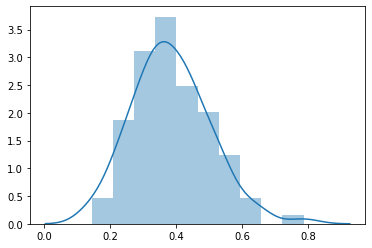

In [244]:
rand_score = np.array(rand_score)
print("Area under curve: %0.2f (+/- %0.2f)" % (np.mean(rand_score), np.std(rand_score) * 2))
print(f'95% CI is {np.quantile(rand_score, [0.025, 0.975])}')
sns.distplot(rand_score)

In [52]:
## use sklearn permutation test
from sklearn.model_selection import permutation_test_score
score, permutation_scores, pvalue = permutation_test_score(
    model, X, condition_label, scoring="roc_auc", cv=cv, n_permutations=100, n_jobs=8, 
    verbose=5, random_state=138)

print("Classification score %s (pvalue : %s)" % (score, pvalue))

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:   10.7s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:  1.9min


Classification score 0.8636363636363636 (pvalue : 0.12871287128712872)


[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  3.1min finished


## Try some visualization
- See a few dimensonality reduction options to visualize the results
- Use ecluduan distance
- PCA?
- Other?

In [20]:
## Start with euclidian distance - using log
#dist = numpy.linalg.norm(a-b)
dist = np.linalg.norm(ketArr_reshape[1] - ketArr_reshape[0])
dist

10701.918

In [36]:
# loop and test distance between all subjects
distSub = []
dist = []
for i in range(X.shape[0]):
    for n in range(X.shape[0]):
        dtSub = np.linalg.norm(X[i]- X[n])
    distSub.append(dtSub)
    dist.append(distSub)
    

In [41]:
np.array(dist).shape
dist

[[10293.386,
  10480.314,
  10000.209,
  14875.146,
  11418.049,
  10281.256,
  15685.136,
  12374.759,
  10993.589,
  11539.266,
  14779.165,
  12761.358,
  19746.383,
  9801.506,
  12853.012,
  14321.41,
  9583.957,
  16590.424,
  10579.277,
  9707.959,
  12944.341,
  11667.853,
  0.0],
 [10293.386,
  10480.314,
  10000.209,
  14875.146,
  11418.049,
  10281.256,
  15685.136,
  12374.759,
  10993.589,
  11539.266,
  14779.165,
  12761.358,
  19746.383,
  9801.506,
  12853.012,
  14321.41,
  9583.957,
  16590.424,
  10579.277,
  9707.959,
  12944.341,
  11667.853,
  0.0],
 [10293.386,
  10480.314,
  10000.209,
  14875.146,
  11418.049,
  10281.256,
  15685.136,
  12374.759,
  10993.589,
  11539.266,
  14779.165,
  12761.358,
  19746.383,
  9801.506,
  12853.012,
  14321.41,
  9583.957,
  16590.424,
  10579.277,
  9707.959,
  12944.341,
  11667.853,
  0.0],
 [10293.386,
  10480.314,
  10000.209,
  14875.146,
  11418.049,
  10281.256,
  15685.136,
  12374.759,
  10993.589,
  11539.266,


In [45]:
sns.scatterplot(dist[:,0], dist[:,1])

TypeError: list indices must be integers or slices, not tuple

In [215]:
## PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_r = pca.fit(X).transform(X)

In [178]:
X_r.shape

(23, 10)

In [216]:
print('explained variance ratio (first two components): %s'
      % str(pca.explained_variance_ratio_))

explained variance ratio (first two components): [0.14201081 0.09177829]


In [218]:
colors = ['navy', 'red']
lw = 2
y = np.array(condition_label) # make it an array so we can get mask for each place
target_names = ['Midazolam','Ketamine']
for color, i, target_name in zip(colors, [0, 1], target_names):
    plt.scatter(X_r[y == i, 5], X_r[y == i, 4], color=color, alpha=.8, lw=lw,
                label=target_name)


IndexError: index 5 is out of bounds for axis 1 with size 2

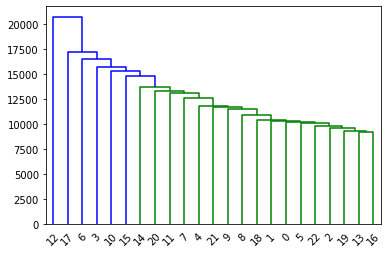

In [219]:
from scipy.cluster.hierarchy import dendrogram, linkage, cut_tree
# That's the hierarchical clustering step
hier = linkage(X, method='average', metric='euclidean')#''euclidean') # scipy's hierarchical clustering
# HAC proceeds by iteratively merging brain regions, which can be visualized with a tree
res = dendrogram(hier, get_leaves=True) # Generate a dendrogram from the hierarchy

In [220]:
# the order of merging above give us a good order to visualize the matrix
order = res.get('leaves') # Extract the order on parcels from the dendrogram
print(condition_label[order]) # print group of subjects, according to order

[0 0 1 1 1 0 0 0 1 1 1 0 1 1 0 1 1 1 0 1 0 0 0]


In [221]:
part = np.squeeze(cut_tree(hier, n_clusters=2)) # Cut the hierarchy
# Each entry of the vector part is a parcel, and codes for the number of the network of this parcel
print(part) # e.g. parcel #7 is in cluster 5. What is the cluster of parcel number 10?

[0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]


In [222]:
from sklearn.cluster import FeatureAgglomeration
fa = FeatureAgglomeration(n_clusters=2)
X_f = fa.fit(X).transform(X)

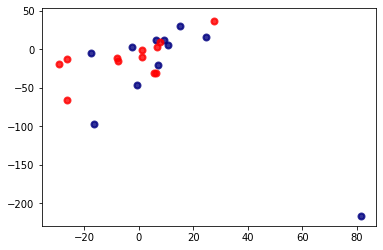

In [223]:
colors = ['navy', 'red']
lw = 2
y = np.array(condition_label) # make it an array so we can get mask for each place
target_names = ['Midazolam','Ketamine']
for color, i, target_name in zip(colors, [0, 1], target_names):
    plt.scatter(X_f[y == i, 0], X_f[y == i, 1], color=color, alpha=.8, lw=lw,
                label=target_name)

In [226]:
# from sklearn import random_projection
# transformer = random_projection.GaussianRandomProjection(n_components = 2)
# X_new = transformer.fit_transform(X)
# X_new.shape

from sklearn import random_projection

transformer = random_projection.SparseRandomProjection(n_components = 2)
X_new = transformer.fit_transform(X)
X_new.shape


(23, 2)

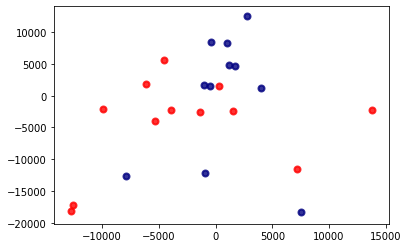

In [227]:
colors = ['navy', 'red']
lw = 2
y = np.array(condition_label) # make it an array so we can get mask for each place
target_names = ['Midazolam','Ketamine']
for color, i, target_name in zip(colors, [0, 1], target_names):
    plt.scatter(X_new[y == i, 0], X_new[y == i, 1], color=color, alpha=.8, lw=lw,
                label=target_name)

In [252]:
from sklearn.decomposition import FastICA

transformer = FastICA(n_components=2,
        random_state=0, algorithm='parallel',
                     fun='cube')
X_transformed = transformer.fit_transform(X)
X_transformed.shape

(23, 2)

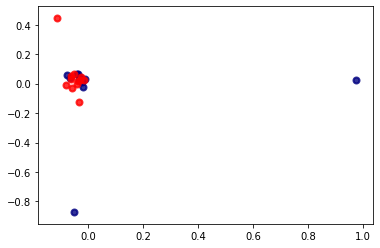

In [253]:
colors = ['navy', 'red']
lw = 2
y = np.array(condition_label) # make it an array so we can get mask for each place
target_names = ['Midazolam','Ketamine']
for color, i, target_name in zip(colors, [0, 1], target_names):
    plt.scatter(X_transformed[y == i, 0], X_transformed[y == i, 1], color=color, alpha=.8, lw=lw,
                label=target_name)